In [1]:
!wget  https://anaconda.org/pytorch/faiss-cpu/1.2.1/download/linux-64/faiss-cpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
!tar xvjf faiss-cpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
!cp -r lib/python3.6/site-packages/* /usr/local/lib/python3.6/dist-packages/
!pip install mkl
!pip install faiss-cpu


'wget' is not recognized as an internal or external command,
operable program or batch file.
tar: Error opening archive: Failed to open 'faiss-cpu-1.2.1-py36_cuda9.0.176_1.tar.bz2'
'cp' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
import torch
import torchvision
import numpy as np
from copy import deepcopy
import argparse
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
import torch.nn.functional as F

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
import faiss


In [2]:
# Workaround for Google Colab's default args
sys.argv = ['']

# Define your argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--debug", action='store_true', help="Debug mode")
args = ap.parse_args()

# Example of using the parsed arguments
if args.debug:
    print("Debug mode is ON")

# Set a manual seed
torch.manual_seed(0)

In [3]:
### Hyperparameters
val_split = 0.1
unlabelled_size = 0.995
lr = 0.0005
batch_size = 64
num_epochs = 100
label_iterations = 5

### Setup MNIST dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])
#train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
#train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)


debug = args.debug
if debug:
    train_dataset.data = train_dataset.data[:1000]
    train_dataset.targets = train_dataset.targets[:1000]

    torch.set_num_threads(4)
val_dataset = deepcopy(train_dataset)


Files already downloaded and verified


In [4]:
train_size = int((1 - val_split) * len(train_dataset))
val_size = len(train_dataset) - train_size
indexes = torch.randperm(len(train_dataset)).tolist()
# Define validation set

indexes_val = np.array(indexes[train_size:])
val_dataset.targets = np.array(val_dataset.targets)[indexes_val]
val_dataset.data = val_dataset.data[indexes_val]
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False)

# Define training set
indexes_train = np.array(indexes[train_size:])
train_dataset.targets = np.array(train_dataset.targets)[indexes_val]
train_dataset.data = train_dataset.data[indexes_val]


# Split training data into labelled and unlabelled
unlabelled_size = int(unlabelled_size * len(train_dataset))
indexes_train = torch.randperm(len(train_dataset)).tolist()  # Redefine indexes_train
unlabbelled_dataset = deepcopy(train_dataset)
unlabbelled_dataset.targets = unlabbelled_dataset.targets[indexes_train[:unlabelled_size]]
unlabbelled_dataset.data = unlabbelled_dataset.data[indexes_train[:unlabelled_size]]
train_dataset.targets = train_dataset.targets[indexes_train[unlabelled_size:]]
train_dataset.data = train_dataset.data[indexes_train[unlabelled_size:]]
unlabbelled_dataset.targets = unlabbelled_dataset.targets
unlabbelled_dataset.data = unlabbelled_dataset.data
start_train_dataset = deepcopy(train_dataset)  # Save for baseline
start_unlabbelled_dataset = deepcopy(unlabbelled_dataset)  # Save for baseline


def transfer_unlabelled_to_labeled(unlabelled_dataset, train_dataset, indexes):
    # Ensure indexes are a numpy array
    indexes = np.isin(np.arange(len(unlabelled_dataset.targets)), indexes)

    # Add selected samples to train dataset
    train_dataset.targets = np.concatenate([train_dataset.targets, unlabelled_dataset.targets[indexes]])
    train_dataset.data = np.concatenate([train_dataset.data, unlabelled_dataset.data[indexes]])

    # Remove selected samples from unlabelled dataset
    mask = np.ones(len(unlabelled_dataset.targets), dtype=bool)
    mask[indexes] = False
    unlabelled_dataset.targets = unlabelled_dataset.targets[mask]
    unlabelled_dataset.data = unlabelled_dataset.data[mask]

    return train_dataset, unlabelled_dataset


def transfer_unlabelled_to_labeled2(unlabbelled_dataset, train_dataset, indexes):
    # Convert indexes to boolean mask
    indexes = torch.tensor([i in indexes for i in range(len(unlabbelled_dataset.targets))])

    print(type(train_dataset.targets), train_dataset.targets.dtype)
    print(type(unlabbelled_dataset.targets), unlabbelled_dataset.targets.dtype)

    train_dataset.targets = torch.cat([train_dataset.targets, unlabbelled_dataset.targets[indexes]])
    train_dataset.data = torch.cat([train_dataset.data, unlabbelled_dataset.data[indexes]])
    unlabbelled_dataset.targets = unlabbelled_dataset.targets[~indexes]
    unlabbelled_dataset.data = unlabbelled_dataset.data[~indexes]

    return train_dataset, unlabbelled_dataset

def validate_model(model, val_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Setup model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 10)
# Modify input layer to accept 1 channel
model.conv1 = torch.nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

c:\Users\kubko\anaconda3\envs\DeeplearnignDTU\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kubko\anaconda3\envs\DeeplearnignDTU\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [5]:
train_size

45000

In [6]:
unlabelled_size

4975

In [7]:
val_size

5000

In [8]:
start_train_dataset

Dataset CIFAR10
    Number of datapoints: 25
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [9]:
model_parameters = deepcopy(model.state_dict())
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, val_interval=1):
    accuracies = []
    for epoch in tqdm(range(num_epochs)):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % val_interval == 0:
            val_accuracy = validate_model(model, val_loader, device)
            accuracies.append(val_accuracy)
            print(f'Epoch {epoch + 1}, Accuracy: {val_accuracy:.2f}%')
    return accuracies


def label_iteration(model, train_dataset, unlabelled_dataset, device, top_frac=0.01, method="uncertainty"):
    model.eval()
    predictions = []
    unlabelled_loader = torch.utils.data.DataLoader(unlabelled_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    # Collect predictions
    with torch.no_grad():
        for images, _ in tqdm(unlabelled_loader, desc=f"Evaluating {method}"):
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)  # Get probabilities
            predictions.extend(probs.cpu().numpy())

    predictions = torch.tensor(predictions)

    if method == "uncertainty":
        #entropy: -sum(p * log(p))
        entropy = -torch.sum(predictions * torch.log(predictions + 1e-10), dim=1)
        top_indices = torch.argsort(entropy, descending=True)[:int(top_frac * len(predictions))]
    elif method == "margin":
        #margin: difference between top two probabilities
        sorted_probs, _ = torch.sort(predictions, descending=True, dim=1)
        margin = sorted_probs[:, 0] - sorted_probs[:, 1]
        top_indices = torch.argsort(margin)[:int(top_frac * len(predictions))]  # Smallest margins
    else:
        raise ValueError("Invalid method. Choose between 'uncertainty' and 'margin'.")

    print(f"Adding {len(top_indices)} images to training set using {method}-based selection")
    train_dataset, unlabelled_dataset = transfer_unlabelled_to_labeled(unlabelled_dataset, train_dataset, top_indices)

    return train_dataset, unlabelled_dataset


In [10]:
def visualize_clusters(features, cluster_labels, method="tsne", num_clusters=10):
    reducer = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
    reduced_features = reducer.fit_transform(features)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        reduced_features[:, 0],
        reduced_features[:, 1],
        c=cluster_labels,
        cmap='tab20',
        s=10,
        alpha=0.7
    )
    plt.colorbar(scatter, label="Cluster ID")
    plt.title(f"Cluster Visualization using {method.upper()}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()

In [11]:
import matplotlib.pyplot as plt

def visualize_active_learning(features, cluster_labels, selected_indices, method="tsne", num_clusters=10):
    if method == "tsne":
        reducer = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
    elif method == "pca":
        reducer = PCA(n_components=2)
    else:
        raise ValueError("Invalid method. Choose 'tsne' or 'pca'.")

    reduced_features = reducer.fit_transform(features)

    # Plot clusters
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        reduced_features[:, 0],
        reduced_features[:, 1],
        c=cluster_labels,
        cmap='tab20',
        s=10,
        alpha=0.7
    )
    selected_points = reduced_features[selected_indices]
    plt.scatter(
        selected_points[:, 0],
        selected_points[:, 1],
        color='red',
        marker='x',
        s=50,
        label='Selected Points'
    )

    plt.colorbar(scatter, label="Cluster ID")
    plt.title(f"Cluster Visualization with Active Learning ({method.upper()})")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.show()

In [12]:
  
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import pairwise_distances

def label_iteration_with_dbscan(model, train_dataset, unlabelled_dataset, device, budget, eps=0.2, min_samples=500):
    model.eval()
    features = []
    unlabelled_loader = torch.utils.data.DataLoader(unlabelled_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    with torch.no_grad():
        for images, _ in tqdm(unlabelled_loader, desc="Extracting features"):
            images = images.to(device)
            outputs = model(images).view(images.size(0), -1)
            features.append(outputs.cpu().numpy())
    features = np.vstack(features)

    if eps is None:
        distances = pairwise_distances(features)
        eps = np.median(distances)
        print(f"Automatically chosen eps: {eps:.2f}")
        plt.hist(distances.ravel(), bins=50)
        plt.title("Pairwise Distance Distribution")
        plt.xlabel("Distance")
        plt.ylabel("Frequency")
        plt.show()

    # Apply DBSCAN
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    cluster_labels = clustering.fit_predict(features)

     # Debugging: Cluster distribution
    unique, counts = np.unique(cluster_labels, return_counts=True)
    print(f"Cluster distribution: {dict(zip(unique, counts))}")

    # Handle noise points (label -1 in DBSCAN)
    if -1 in cluster_labels:
        print(f"Found {sum(cluster_labels == -1)} noise points. Excluding them from selection.")
        valid_indices = np.where(cluster_labels != -1)[0]
        cluster_labels = cluster_labels[valid_indices]
        features = features[valid_indices]
    else:
        valid_indices = np.arange(len(cluster_labels))

    def compute_density(features, neighbors):
        d = features.shape[1]
        features = features.astype(np.float32)
        index = faiss.IndexFlatL2(d)
        index.add(features)
        distances, _ = index.search(features, neighbors + 1)
        distances = distances[:, 1:]
        return 1 / (distances.mean(axis=1) + 1e-5)

    densities = compute_density(features, neighbors=min_samples)

    # Collect points from clusters
    cluster_indices = {i: [] for i in np.unique(cluster_labels)}
    for idx, label in enumerate(cluster_labels):
        cluster_indices[label].append(idx)

    selected_indices = []
    for cluster, indices in cluster_indices.items():
        print("-----hello-----")
        if indices:
            print("-----hi-----")
            cluster_features = features[indices]
            cluster_densities = densities[indices]
            top_5_indices = np.argsort(cluster_densities)[-10:]
            selected_indices.extend([indices[idx] for idx in top_5_indices])
        if len(selected_indices) >= budget:
            break

    train_dataset, unlabelled_dataset = transfer_unlabelled_to_labeled(unlabelled_dataset, train_dataset, selected_indices)
    print(f"Selected {len(selected_indices)} samples for labeling.")
    return train_dataset, unlabelled_dataset


In [13]:
from sklearn.cluster import HDBSCAN
from sklearn.metrics.pairwise import pairwise_distances

def label_iteration_with_hdbscan(model, train_dataset, unlabelled_dataset, device, budget, min_cluster_size=20, min_samples=10):
    model.eval()
    features = []
    unlabelled_loader = torch.utils.data.DataLoader(unlabelled_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    # Extract features
    with torch.no_grad():
        for images, _ in tqdm(unlabelled_loader, desc="Extracting features"):
            images = images.to(device)
            outputs = model(images).view(images.size(0), -1)
            features.append(outputs.cpu().numpy())
    features = np.vstack(features)

    # Perform HDBSCAN clustering
    clusterer = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, metric='euclidean')
    cluster_labels = clusterer.fit_predict(features)

    # Print cluster information
    unique_clusters, counts = np.unique(cluster_labels, return_counts=True)
    print(f"Cluster distribution: {dict(zip(unique_clusters, counts))}")

    # Compute densities for each sample
    cluster_indices = {i: [] for i in range(len(unique_clusters)) if i != -1}
    for idx, label in enumerate(cluster_labels):
        if label != -1:  # Ignore noise points (-1)
            cluster_indices[label].append(idx)

    def compute_density(features, neighbors):
        d = features.shape[1]
        features = features.astype(np.float32)
        index = faiss.IndexFlatL2(d)
        index.add(features)
        distances, _ = index.search(features, neighbors + 1)
        distances = distances[:, 1:]
        return 1 / (distances.mean(axis=1) + 1e-5)

    densities = compute_density(features, neighbors=min_samples)

    selected_indices = []
    for cluster, indices in cluster_indices.items():
        cluster_features = features[indices]
        cluster_densities = densities[indices]
        top_5_indices = np.argsort(cluster_densities)[-10:]
        selected_indices.extend([indices[idx] for idx in top_5_indices])
        if len(selected_indices) >= budget:
            break

    # Transfer selected samples to labeled dataset
    train_dataset, unlabelled_dataset = transfer_unlabelled_to_labeled(unlabelled_dataset, train_dataset, selected_indices)
    print(f"Selected {len(selected_indices)} samples for labeling.")

    return train_dataset, unlabelled_dataset

In [14]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

def label_iteration_with_Herar(model, train_dataset, unlabelled_dataset, device, budget, num_neighbors=20, num_clusters=10):
    model.eval()
    features = []
    unlabelled_loader = torch.utils.data.DataLoader(unlabelled_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    with torch.no_grad():
        for images, _ in tqdm(unlabelled_loader, desc="Extracting features"):
            images = images.to(device)
            outputs = model(images).view(images.size(0), -1)
            features.append(outputs.cpu().numpy())
    features = np.vstack(features)

    num_clusters = min(len(unlabelled_dataset), num_clusters)

    #kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    #cluster_labels = kmeans.fit_predict(features)
    #visualize_clusters(features, cluster_labels, method="tsne", num_clusters=10)

    clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
    cluster_labels = clustering.fit_predict(features)
    dbi = davies_bouldin_score(features, cluster_labels)
    print(f"Davies-Bouldin Index: {dbi}")
    
    
    def compute_density(features, neighbors):
        d = features.shape[1]
        features = features.astype(np.float32)
        index = faiss.IndexFlatL2(d)
        index.add(features)
        distances, _ = index.search(features, neighbors + 1)
        distances = distances[:, 1:]
        return 1 / (distances.mean(axis=1) + 1e-5)

    densities = compute_density(features, num_neighbors)

    cluster_indices = {i: [] for i in range(num_clusters)}
    for idx, label in enumerate(cluster_labels):
        cluster_indices[label].append(idx)

    selected_indices = []
    for cluster, indices in cluster_indices.items():
        if indices:
            cluster_features = features[indices]
            cluster_densities = densities[indices]
            top_5_indices = np.argsort(cluster_densities)[-10:]
            selected_indices.extend([indices[idx] for idx in top_5_indices])
        if len(selected_indices) >= budget:
            break

    visualize_active_learning(features, cluster_labels, selected_indices, method="tsne", num_clusters=num_clusters)
    train_dataset, unlabelled_dataset = transfer_unlabelled_to_labeled(unlabelled_dataset, train_dataset, selected_indices)
    print(f"Selected {len(selected_indices)} samples for labeling.")
    return train_dataset, unlabelled_dataset

In [15]:
from sklearn.metrics import davies_bouldin_score
def label_iteration_with_clustering(model, train_dataset, unlabelled_dataset, device, budget, num_neighbors=20, num_clusters=10):
    model.eval()
    features = []
    unlabelled_loader = torch.utils.data.DataLoader(unlabelled_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    with torch.no_grad():
        for images, _ in tqdm(unlabelled_loader, desc="Extracting features"):
            images = images.to(device)
            outputs = model(images).view(images.size(0), -1)
            features.append(outputs.cpu().numpy())
    features = np.vstack(features)

    num_clusters = min(len(unlabelled_dataset), num_clusters)

    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(features)
    dbi = davies_bouldin_score(features, cluster_labels)
    print(f"Davies-Bouldin Index: {dbi}")
    #visualize_clusters(features, cluster_labels, method="tsne", num_clusters=10)
    
    def compute_density(features, neighbors):
        d = features.shape[1]
        features = features.astype(np.float32)
        index = faiss.IndexFlatL2(d)
        index.add(features)
        distances, _ = index.search(features, neighbors + 1)
        distances = distances[:, 1:]
        return 1 / (distances.mean(axis=1) + 1e-5)

    densities = compute_density(features, num_neighbors)

    cluster_indices = {i: [] for i in range(num_clusters)}
    for idx, label in enumerate(cluster_labels):
        cluster_indices[label].append(idx)

    selected_indices = []
    for cluster, indices in cluster_indices.items():
        if indices:
            cluster_features = features[indices]
            cluster_densities = densities[indices]
            top_5_indices = np.argsort(cluster_densities)[-10:]
            selected_indices.extend([indices[idx] for idx in top_5_indices])
        if len(selected_indices) >= budget:
            break

    visualize_active_learning(features, cluster_labels, selected_indices, method="tsne", num_clusters=num_clusters)
    train_dataset, unlabelled_dataset = transfer_unlabelled_to_labeled(unlabelled_dataset, train_dataset, selected_indices)
    print(f"Selected {len(selected_indices)} samples for labeling.")
    return train_dataset, unlabelled_dataset


 10%|█         | 10/100 [00:01<00:10,  8.43it/s]

Epoch 10, Accuracy: 8.68%


 20%|██        | 20/100 [00:02<00:09,  8.22it/s]

Epoch 20, Accuracy: 8.68%


 30%|███       | 30/100 [00:03<00:09,  7.51it/s]

Epoch 30, Accuracy: 8.68%


 40%|████      | 40/100 [00:05<00:08,  7.40it/s]

Epoch 40, Accuracy: 8.68%


 50%|█████     | 50/100 [00:06<00:06,  7.52it/s]

Epoch 50, Accuracy: 8.68%


 60%|██████    | 60/100 [00:07<00:05,  7.56it/s]

Epoch 60, Accuracy: 8.68%


 70%|███████   | 70/100 [00:09<00:03,  7.58it/s]

Epoch 70, Accuracy: 8.68%


 80%|████████  | 80/100 [00:10<00:02,  7.54it/s]

Epoch 80, Accuracy: 8.68%


 90%|█████████ | 90/100 [00:11<00:01,  7.57it/s]

Epoch 90, Accuracy: 8.68%


100%|██████████| 100/100 [00:13<00:00,  7.66it/s]


Epoch 100, Accuracy: 8.68%


Evaluating uncertainty: 100%|██████████| 72/72 [00:01<00:00, 46.69it/s]
C:\Users\kubko\AppData\Local\Temp\ipykernel_24524\4117777955.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  predictions = torch.tensor(predictions)


Adding 128 images to training set using uncertainty-based selection


 12%|█▏        | 12/100 [00:02<00:20,  4.33it/s]

Epoch 10, Accuracy: 17.84%


 22%|██▏       | 22/100 [00:03<00:16,  4.67it/s]

Epoch 20, Accuracy: 22.58%


 32%|███▏      | 32/100 [00:05<00:14,  4.65it/s]

Epoch 30, Accuracy: 22.56%


 42%|████▏     | 42/100 [00:07<00:12,  4.59it/s]

Epoch 40, Accuracy: 23.08%


 52%|█████▏    | 52/100 [00:09<00:10,  4.79it/s]

Epoch 50, Accuracy: 22.92%


 62%|██████▏   | 62/100 [00:11<00:07,  4.79it/s]

Epoch 60, Accuracy: 23.16%


 72%|███████▏  | 72/100 [00:12<00:05,  5.00it/s]

Epoch 70, Accuracy: 23.24%


 82%|████████▏ | 82/100 [00:14<00:03,  5.20it/s]

Epoch 80, Accuracy: 23.18%


 92%|█████████▏| 92/100 [00:16<00:01,  5.23it/s]

Epoch 90, Accuracy: 23.30%


100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


Epoch 100, Accuracy: 23.26%


Evaluating uncertainty: 100%|██████████| 70/70 [00:01<00:00, 54.88it/s]


Adding 124 images to training set using uncertainty-based selection


 11%|█         | 11/100 [00:02<00:33,  2.68it/s]

Epoch 10, Accuracy: 27.76%


 21%|██        | 21/100 [00:04<00:28,  2.80it/s]

Epoch 20, Accuracy: 29.78%


 31%|███       | 31/100 [00:07<00:24,  2.87it/s]

Epoch 30, Accuracy: 29.96%


 41%|████      | 41/100 [00:09<00:20,  2.90it/s]

Epoch 40, Accuracy: 30.50%


 51%|█████     | 51/100 [00:11<00:17,  2.87it/s]

Epoch 50, Accuracy: 30.76%


 61%|██████    | 61/100 [00:13<00:13,  2.95it/s]

Epoch 60, Accuracy: 30.66%


 71%|███████   | 71/100 [00:15<00:09,  2.93it/s]

Epoch 70, Accuracy: 30.74%


 81%|████████  | 81/100 [00:17<00:06,  2.85it/s]

Epoch 80, Accuracy: 31.02%


 91%|█████████ | 91/100 [00:20<00:03,  2.98it/s]

Epoch 90, Accuracy: 30.92%


100%|██████████| 100/100 [00:22<00:00,  4.51it/s]


Epoch 100, Accuracy: 30.98%


Evaluating uncertainty: 100%|██████████| 68/68 [00:01<00:00, 57.05it/s]


Adding 121 images to training set using uncertainty-based selection


 11%|█         | 11/100 [00:02<00:34,  2.57it/s]

Epoch 10, Accuracy: 33.46%


 21%|██        | 21/100 [00:05<00:31,  2.54it/s]

Epoch 20, Accuracy: 34.72%


 31%|███       | 31/100 [00:08<00:26,  2.57it/s]

Epoch 30, Accuracy: 35.78%


 41%|████      | 41/100 [00:10<00:24,  2.42it/s]

Epoch 40, Accuracy: 36.20%


 51%|█████     | 51/100 [00:13<00:19,  2.54it/s]

Epoch 50, Accuracy: 36.48%


 61%|██████    | 61/100 [00:16<00:15,  2.52it/s]

Epoch 60, Accuracy: 36.62%


 71%|███████   | 71/100 [00:19<00:11,  2.52it/s]

Epoch 70, Accuracy: 37.06%


 81%|████████  | 81/100 [00:21<00:07,  2.55it/s]

Epoch 80, Accuracy: 36.54%


 91%|█████████ | 91/100 [00:24<00:03,  2.55it/s]

Epoch 90, Accuracy: 36.72%


100%|██████████| 100/100 [00:27<00:00,  3.69it/s]


Epoch 100, Accuracy: 36.62%


Evaluating uncertainty: 100%|██████████| 66/66 [00:01<00:00, 49.74it/s]


Adding 117 images to training set using uncertainty-based selection


 10%|█         | 10/100 [00:03<00:49,  1.83it/s]

Epoch 10, Accuracy: 35.92%


 20%|██        | 20/100 [00:06<00:43,  1.84it/s]

Epoch 20, Accuracy: 37.48%


 30%|███       | 30/100 [00:09<00:38,  1.81it/s]

Epoch 30, Accuracy: 37.82%


 40%|████      | 40/100 [00:13<00:35,  1.68it/s]

Epoch 40, Accuracy: 38.32%


 50%|█████     | 50/100 [00:16<00:27,  1.81it/s]

Epoch 50, Accuracy: 38.16%


 60%|██████    | 60/100 [00:19<00:21,  1.82it/s]

Epoch 60, Accuracy: 38.16%


 70%|███████   | 70/100 [00:23<00:16,  1.82it/s]

Epoch 70, Accuracy: 38.40%


 81%|████████  | 81/100 [00:26<00:08,  2.24it/s]

Epoch 80, Accuracy: 38.46%


 90%|█████████ | 90/100 [00:29<00:05,  1.81it/s]

Epoch 90, Accuracy: 38.54%


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Epoch 100, Accuracy: 38.52%
<class 'int'>


 11%|█         | 11/100 [00:03<00:42,  2.11it/s]

Epoch 10, Accuracy: 36.12%


 20%|██        | 20/100 [00:06<00:43,  1.83it/s]

Epoch 20, Accuracy: 41.64%


 30%|███       | 30/100 [00:09<00:38,  1.80it/s]

Epoch 30, Accuracy: 41.38%


 40%|████      | 40/100 [00:13<00:33,  1.77it/s]

Epoch 40, Accuracy: 41.62%


 50%|█████     | 50/100 [00:16<00:29,  1.68it/s]

Epoch 50, Accuracy: 41.16%


 60%|██████    | 60/100 [00:20<00:23,  1.69it/s]

Epoch 60, Accuracy: 41.76%


 70%|███████   | 70/100 [00:23<00:16,  1.83it/s]

Epoch 70, Accuracy: 41.86%


 80%|████████  | 80/100 [00:26<00:11,  1.76it/s]

Epoch 80, Accuracy: 41.96%


 90%|█████████ | 90/100 [00:30<00:06,  1.57it/s]

Epoch 90, Accuracy: 42.10%


100%|██████████| 100/100 [00:33<00:00,  2.96it/s]

Epoch 100, Accuracy: 42.24%


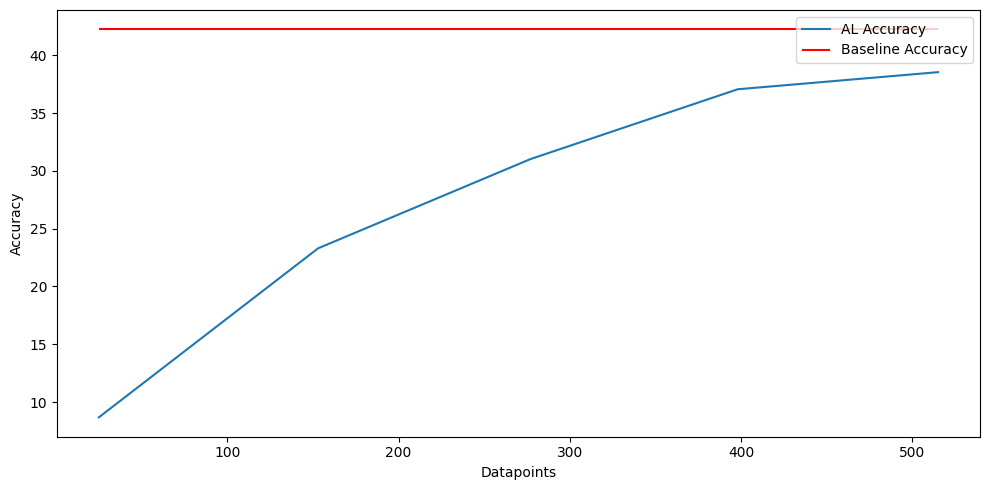

In [23]:
train_dataset.data = start_train_dataset.data
train_dataset.targets = start_train_dataset.targets
model.load_state_dict(model_parameters)

## Run active learning
datapoint_list = []
accuracy_list = []
for i in range(label_iterations):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    model.load_state_dict(model_parameters)  # Important to reset the model each time
    accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, val_interval=10)
    datapoint_list.append(len(train_dataset))
    accuracy_list.append(accuracies)
    if i < label_iterations - 1:
        train_dataset, unlabbelled_dataset = label_iteration(model, train_dataset, unlabbelled_dataset, device, top_frac=0.028)

        
n_datapoints = len(train_dataset) - len(start_train_dataset)
print(type(n_datapoints))
model.load_state_dict(model_parameters)
train_dataset.data = np.concatenate([start_train_dataset.data, start_unlabbelled_dataset.data[:n_datapoints]])
train_dataset.targets = np.concatenate([start_train_dataset.targets, start_unlabbelled_dataset.targets[:n_datapoints]])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False)
baseline_accuracy = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, val_interval=10)


datapoints = np.array(datapoint_list)
accuracies = np.array(accuracy_list).max(-1)
plt.figure(figsize=(10, 5))
plt.plot(datapoints, accuracies, label='AL Accuracy')
plt.hlines(max(baseline_accuracy), min(datapoints), max(datapoints), label='Baseline Accuracy', color='red')
plt.xlabel('Datapoints')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
def run_active_learning(train_dataset,start_train_dataset,unlabbelled_dataset,start_unlabbelled_dataset,model,model_parameters,val_loader,criterion,optimizer,device,label_iterations, cluster=label_iteration_with_Herar):
    train_dataset.data = start_train_dataset.data
    train_dataset.targets = start_train_dataset.targets
    model.load_state_dict(model_parameters)

    ## Run active learning
    datapoint_list = []
    accuracy_list = []
    for i in range(label_iterations):
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        model.load_state_dict(model_parameters)  # Important to reset the model each time
        accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, val_interval=10)
        datapoint_list.append(len(train_dataset))
        accuracy_list.append(accuracies)
        if i < label_iterations - 1:
            train_dataset, unlabbelled_dataset = cluster(model, train_dataset, unlabbelled_dataset, device, budget=150)

    n_datapoints = int((len(train_dataset) - len(start_train_dataset))/4)
    print(len(train_dataset) - len(start_train_dataset))
    train_dataset.data = start_train_dataset.data
    train_dataset.targets = start_train_dataset.targets
    baseline_datapoint_list = []
    baseline_accuracy_list = []
    for i in range(label_iterations-1):
        # Train model
        model.load_state_dict(model_parameters)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False)
        baseline_accuracy = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, val_interval=10)
        baseline_datapoint_list.append(len(train_dataset))
        baseline_accuracy_list.append(baseline_accuracy)
        if i < label_iterations - 1:
            # Add baseline accuracy (no active learning)
            print(n_datapoints)
            train_dataset.data = start_train_dataset.data
            train_dataset.targets = start_train_dataset.targets
            # We reuse the initial training set to reduce run to run variance
            train_dataset.data = np.concatenate([start_train_dataset.data, start_unlabbelled_dataset.data[:n_datapoints]])
            train_dataset.targets = np.concatenate([start_train_dataset.targets, start_unlabbelled_dataset.targets[:n_datapoints]])
            n_datapoints += n_datapoints

        

    # Plot the accuracy
    datapoints = np.array(datapoint_list)
    accuracies = np.array(accuracy_list).max(-1)
    baseline_datapoint = np.array(baseline_datapoint_list)
    baseline_accuracy = np.array(baseline_accuracy_list).max(-1)
    plt.figure(figsize=(10, 5))
    plt.plot(datapoints, accuracies, label='AL Accuracy')
    plt.plot(baseline_datapoint,baseline_accuracy, label='Baseline Accuracy', color='red')
    plt.xlabel('Datapoints')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    #plt.savefig('figs/accuracy.png')
    plt.show()
    return datapoints,accuracies,baseline_datapoint,baseline_accuracy

 10%|█         | 10/100 [00:01<00:17,  5.29it/s]

Epoch 10, Accuracy: 8.68%


 20%|██        | 20/100 [00:03<00:11,  6.97it/s]

Epoch 20, Accuracy: 8.68%


 30%|███       | 30/100 [00:04<00:09,  7.61it/s]

Epoch 30, Accuracy: 8.68%


 40%|████      | 40/100 [00:05<00:07,  8.16it/s]

Epoch 40, Accuracy: 8.68%


 50%|█████     | 50/100 [00:06<00:05,  8.41it/s]

Epoch 50, Accuracy: 8.68%


 60%|██████    | 60/100 [00:07<00:04,  8.56it/s]

Epoch 60, Accuracy: 8.68%


 70%|███████   | 70/100 [00:08<00:03,  8.35it/s]

Epoch 70, Accuracy: 8.68%


 80%|████████  | 80/100 [00:09<00:02,  8.61it/s]

Epoch 80, Accuracy: 8.68%


 90%|█████████ | 90/100 [00:10<00:01,  8.82it/s]

Epoch 90, Accuracy: 8.68%


100%|██████████| 100/100 [00:12<00:00,  8.12it/s]


Epoch 100, Accuracy: 8.68%


Extracting features: 100%|██████████| 78/78 [00:01<00:00, 43.55it/s]
c:\Users\kubko\anaconda3\envs\DeeplearnignDTU\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
c:\Users\kubko\anaconda3\envs\DeeplearnignDTU\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Davies-Bouldin Index: 1.8962227123351956


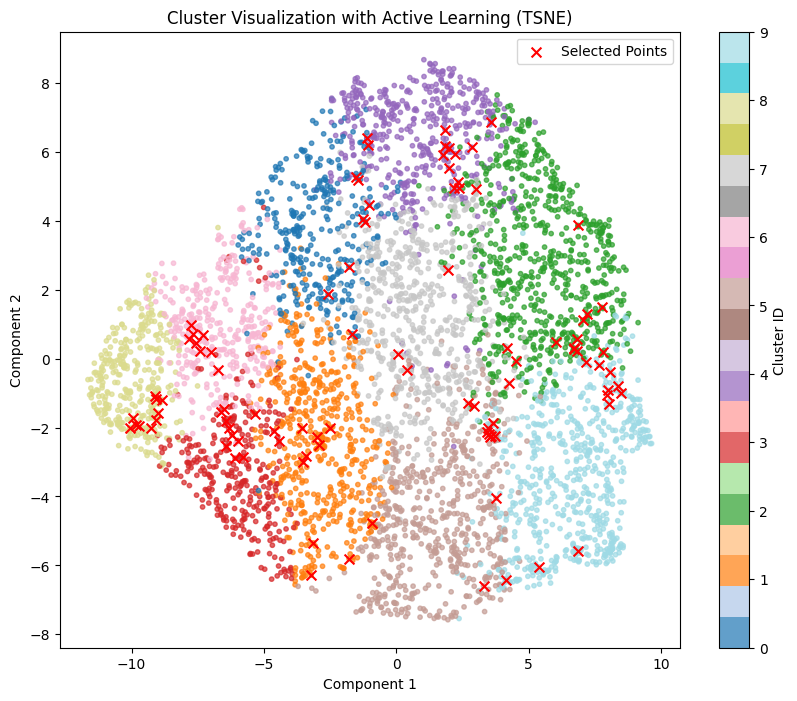

Selected 100 samples for labeling.


 16%|█▌        | 16/100 [00:02<00:08,  9.35it/s]

Epoch 10, Accuracy: 13.38%


 24%|██▍       | 24/100 [00:03<00:09,  8.19it/s]

Epoch 20, Accuracy: 15.02%


 36%|███▌      | 36/100 [00:04<00:07,  8.59it/s]

Epoch 30, Accuracy: 18.94%


 45%|████▌     | 45/100 [00:05<00:06,  8.56it/s]

Epoch 40, Accuracy: 20.86%


 54%|█████▍    | 54/100 [00:07<00:05,  8.27it/s]

Epoch 50, Accuracy: 21.90%


 65%|██████▌   | 65/100 [00:08<00:04,  8.33it/s]

Epoch 60, Accuracy: 22.78%


 75%|███████▌  | 75/100 [00:09<00:02,  8.86it/s]

Epoch 70, Accuracy: 23.40%


 84%|████████▍ | 84/100 [00:11<00:01,  8.49it/s]

Epoch 80, Accuracy: 23.10%


 97%|█████████▋| 97/100 [00:12<00:00,  9.44it/s]

Epoch 90, Accuracy: 23.46%


100%|██████████| 100/100 [00:13<00:00,  7.36it/s]


Epoch 100, Accuracy: 23.08%


Extracting features: 100%|██████████| 77/77 [00:01<00:00, 54.98it/s]
c:\Users\kubko\anaconda3\envs\DeeplearnignDTU\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Davies-Bouldin Index: 1.8430304044690746


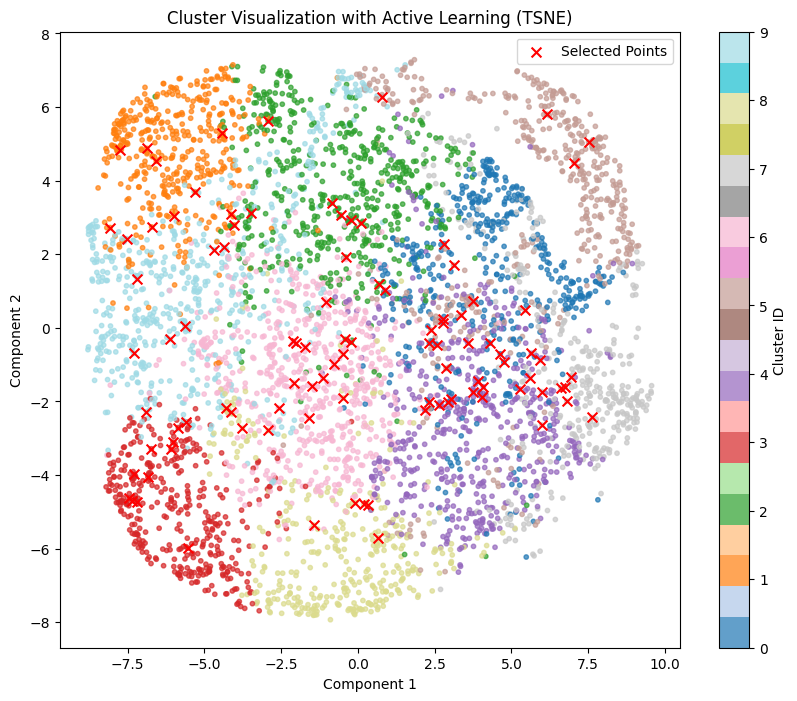

Selected 100 samples for labeling.


 11%|█         | 11/100 [00:01<00:22,  4.02it/s]

Epoch 10, Accuracy: 19.84%


 21%|██        | 21/100 [00:03<00:19,  3.97it/s]

Epoch 20, Accuracy: 27.52%


 31%|███       | 31/100 [00:05<00:17,  3.92it/s]

Epoch 30, Accuracy: 28.10%


 41%|████      | 41/100 [00:07<00:15,  3.90it/s]

Epoch 40, Accuracy: 28.48%


 51%|█████     | 51/100 [00:08<00:12,  3.85it/s]

Epoch 50, Accuracy: 28.52%


 61%|██████    | 61/100 [00:10<00:10,  3.69it/s]

Epoch 60, Accuracy: 28.38%


 71%|███████   | 71/100 [00:12<00:07,  3.91it/s]

Epoch 70, Accuracy: 28.62%


 81%|████████  | 81/100 [00:14<00:04,  3.93it/s]

Epoch 80, Accuracy: 28.54%


 91%|█████████ | 91/100 [00:16<00:02,  3.82it/s]

Epoch 90, Accuracy: 28.66%


100%|██████████| 100/100 [00:17<00:00,  5.63it/s]


Epoch 100, Accuracy: 28.88%


Extracting features: 100%|██████████| 75/75 [00:01<00:00, 57.64it/s]
c:\Users\kubko\anaconda3\envs\DeeplearnignDTU\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Davies-Bouldin Index: 1.705990295222272


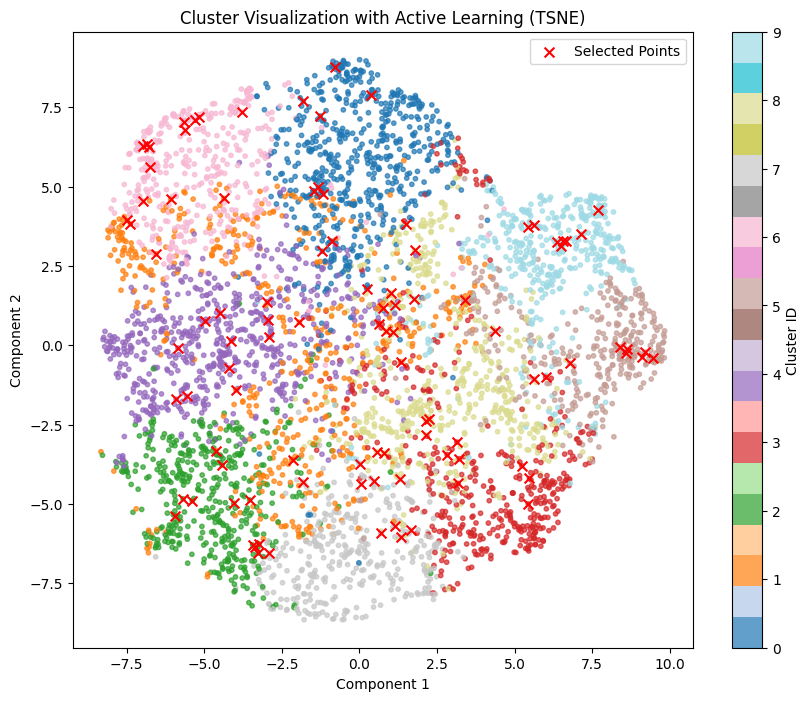

Selected 100 samples for labeling.


 11%|█         | 11/100 [00:02<00:35,  2.54it/s]

Epoch 10, Accuracy: 30.28%


 21%|██        | 21/100 [00:05<00:28,  2.78it/s]

Epoch 20, Accuracy: 32.18%


 31%|███       | 31/100 [00:07<00:25,  2.75it/s]

Epoch 30, Accuracy: 32.48%


 41%|████      | 41/100 [00:09<00:20,  2.81it/s]

Epoch 40, Accuracy: 32.82%


 51%|█████     | 51/100 [00:12<00:17,  2.75it/s]

Epoch 50, Accuracy: 32.44%


 61%|██████    | 61/100 [00:14<00:14,  2.73it/s]

Epoch 60, Accuracy: 32.44%


 71%|███████   | 71/100 [00:17<00:11,  2.50it/s]

Epoch 70, Accuracy: 32.60%


 81%|████████  | 81/100 [00:20<00:07,  2.54it/s]

Epoch 80, Accuracy: 32.60%


 91%|█████████ | 91/100 [00:22<00:03,  2.77it/s]

Epoch 90, Accuracy: 32.50%


100%|██████████| 100/100 [00:24<00:00,  4.05it/s]


Epoch 100, Accuracy: 32.60%


Extracting features: 100%|██████████| 74/74 [00:01<00:00, 57.39it/s]
c:\Users\kubko\anaconda3\envs\DeeplearnignDTU\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Davies-Bouldin Index: 1.6838486371024495


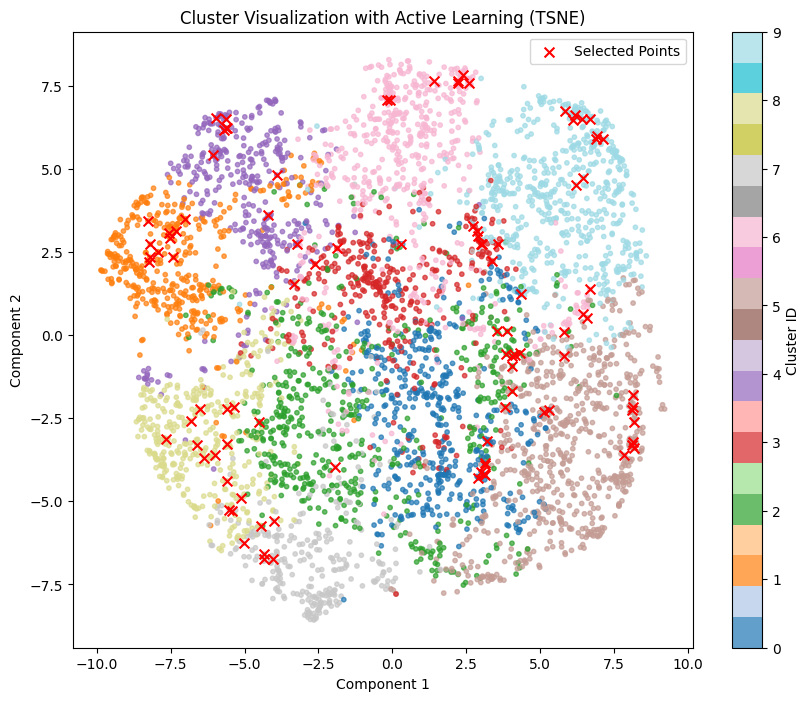

Selected 100 samples for labeling.


 11%|█         | 11/100 [00:02<00:34,  2.59it/s]

Epoch 10, Accuracy: 35.40%


 21%|██        | 21/100 [00:05<00:31,  2.52it/s]

Epoch 20, Accuracy: 36.46%


 30%|███       | 30/100 [00:08<00:33,  2.11it/s]

Epoch 30, Accuracy: 36.82%


 41%|████      | 41/100 [00:10<00:22,  2.57it/s]

Epoch 40, Accuracy: 36.66%


 51%|█████     | 51/100 [00:13<00:20,  2.42it/s]

Epoch 50, Accuracy: 36.90%


 61%|██████    | 61/100 [00:16<00:15,  2.56it/s]

Epoch 60, Accuracy: 37.04%


 71%|███████   | 71/100 [00:19<00:11,  2.55it/s]

Epoch 70, Accuracy: 37.04%


 81%|████████  | 81/100 [00:21<00:07,  2.60it/s]

Epoch 80, Accuracy: 37.14%


 91%|█████████ | 91/100 [00:24<00:03,  2.62it/s]

Epoch 90, Accuracy: 37.08%


100%|██████████| 100/100 [00:26<00:00,  3.74it/s]


Epoch 100, Accuracy: 37.20%
400


 10%|█         | 10/100 [00:01<00:09,  9.52it/s]

Epoch 10, Accuracy: 8.68%


 20%|██        | 20/100 [00:02<00:08,  9.43it/s]

Epoch 20, Accuracy: 8.68%


 30%|███       | 30/100 [00:03<00:07,  9.23it/s]

Epoch 30, Accuracy: 8.68%


 40%|████      | 40/100 [00:04<00:06,  9.15it/s]

Epoch 40, Accuracy: 8.68%


 50%|█████     | 50/100 [00:05<00:05,  9.11it/s]

Epoch 50, Accuracy: 8.68%


 60%|██████    | 60/100 [00:06<00:04,  8.79it/s]

Epoch 60, Accuracy: 8.68%


 70%|███████   | 70/100 [00:07<00:03,  8.77it/s]

Epoch 70, Accuracy: 8.68%


 80%|████████  | 80/100 [00:08<00:02,  8.86it/s]

Epoch 80, Accuracy: 8.68%


 90%|█████████ | 90/100 [00:10<00:01,  8.89it/s]

Epoch 90, Accuracy: 8.68%


100%|██████████| 100/100 [00:11<00:00,  8.99it/s]


Epoch 100, Accuracy: 8.68%
100


 16%|█▌        | 16/100 [00:01<00:08,  9.88it/s]

Epoch 10, Accuracy: 14.74%


 28%|██▊       | 28/100 [00:02<00:06, 11.10it/s]

Epoch 20, Accuracy: 18.36%


 35%|███▌      | 35/100 [00:04<00:07,  8.20it/s]

Epoch 30, Accuracy: 21.96%


 46%|████▌     | 46/100 [00:05<00:06,  8.31it/s]

Epoch 40, Accuracy: 24.00%


 53%|█████▎    | 53/100 [00:06<00:06,  7.25it/s]

Epoch 50, Accuracy: 24.54%


 64%|██████▍   | 64/100 [00:08<00:04,  7.94it/s]

Epoch 60, Accuracy: 24.14%


 75%|███████▌  | 75/100 [00:09<00:03,  8.19it/s]

Epoch 70, Accuracy: 24.28%


 86%|████████▌ | 86/100 [00:10<00:01,  8.29it/s]

Epoch 80, Accuracy: 24.62%


 97%|█████████▋| 97/100 [00:12<00:00,  9.54it/s]

Epoch 90, Accuracy: 24.66%


100%|██████████| 100/100 [00:13<00:00,  7.43it/s]


Epoch 100, Accuracy: 24.54%
200


 12%|█▏        | 12/100 [00:02<00:18,  4.82it/s]

Epoch 10, Accuracy: 23.94%


 21%|██        | 21/100 [00:03<00:18,  4.17it/s]

Epoch 20, Accuracy: 29.74%


 31%|███       | 31/100 [00:05<00:18,  3.74it/s]

Epoch 30, Accuracy: 30.60%


 41%|████      | 41/100 [00:07<00:16,  3.66it/s]

Epoch 40, Accuracy: 30.46%


 51%|█████     | 51/100 [00:09<00:13,  3.66it/s]

Epoch 50, Accuracy: 30.72%


 61%|██████    | 61/100 [00:11<00:10,  3.71it/s]

Epoch 60, Accuracy: 30.70%


 71%|███████   | 71/100 [00:13<00:07,  3.72it/s]

Epoch 70, Accuracy: 30.68%


 81%|████████  | 81/100 [00:15<00:05,  3.70it/s]

Epoch 80, Accuracy: 30.92%


 91%|█████████ | 91/100 [00:17<00:02,  3.61it/s]

Epoch 90, Accuracy: 30.68%


100%|██████████| 100/100 [00:18<00:00,  5.32it/s]


Epoch 100, Accuracy: 30.98%
400


 11%|█         | 11/100 [00:02<00:33,  2.62it/s]

Epoch 10, Accuracy: 34.46%


 21%|██        | 21/100 [00:05<00:33,  2.37it/s]

Epoch 20, Accuracy: 33.44%


 31%|███       | 31/100 [00:08<00:26,  2.59it/s]

Epoch 30, Accuracy: 35.86%


 41%|████      | 41/100 [00:10<00:23,  2.56it/s]

Epoch 40, Accuracy: 37.48%


 51%|█████     | 51/100 [00:13<00:20,  2.41it/s]

Epoch 50, Accuracy: 37.20%


 61%|██████    | 61/100 [00:16<00:15,  2.55it/s]

Epoch 60, Accuracy: 37.10%


 71%|███████   | 71/100 [00:19<00:11,  2.58it/s]

Epoch 70, Accuracy: 37.54%


 81%|████████  | 81/100 [00:21<00:07,  2.55it/s]

Epoch 80, Accuracy: 37.54%


 91%|█████████ | 91/100 [00:24<00:03,  2.53it/s]

Epoch 90, Accuracy: 37.72%


100%|██████████| 100/100 [00:27<00:00,  3.67it/s]

Epoch 100, Accuracy: 37.66%
800


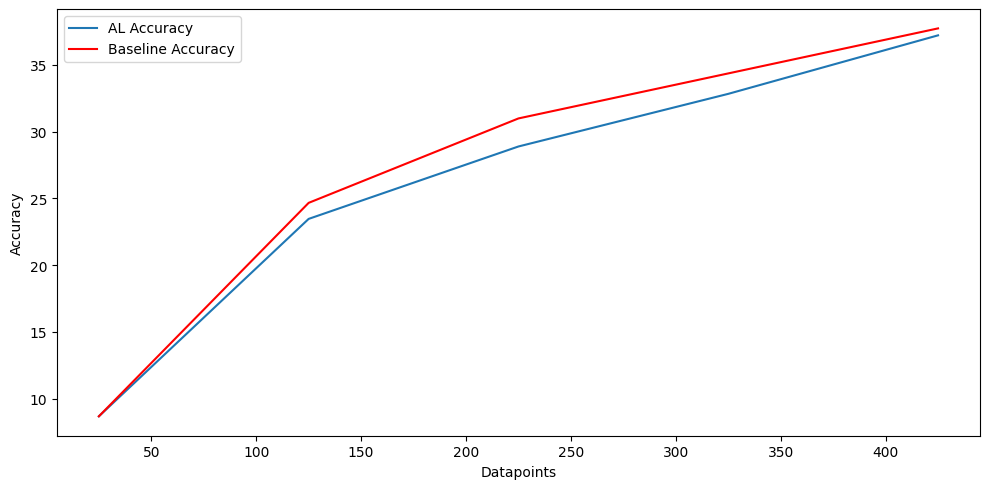

 10%|█         | 10/100 [00:01<00:10,  8.98it/s]

Epoch 10, Accuracy: 8.68%


 20%|██        | 20/100 [00:02<00:09,  8.82it/s]

Epoch 20, Accuracy: 8.68%


 30%|███       | 30/100 [00:03<00:07,  8.84it/s]

Epoch 30, Accuracy: 8.68%


 40%|████      | 40/100 [00:04<00:06,  8.89it/s]

Epoch 40, Accuracy: 8.68%


 50%|█████     | 50/100 [00:05<00:05,  8.91it/s]

Epoch 50, Accuracy: 8.68%


 60%|██████    | 60/100 [00:06<00:04,  8.87it/s]

Epoch 60, Accuracy: 8.68%


 70%|███████   | 70/100 [00:07<00:03,  9.07it/s]

Epoch 70, Accuracy: 8.68%


 80%|████████  | 80/100 [00:08<00:02,  9.12it/s]

Epoch 80, Accuracy: 8.68%


 90%|█████████ | 90/100 [00:09<00:01,  9.13it/s]

Epoch 90, Accuracy: 8.68%


100%|██████████| 100/100 [00:11<00:00,  8.98it/s]


Epoch 100, Accuracy: 8.68%


Extracting features: 100%|██████████| 72/72 [00:01<00:00, 53.32it/s]


Davies-Bouldin Index: 2.5090050050855455


c:\Users\kubko\anaconda3\envs\DeeplearnignDTU\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


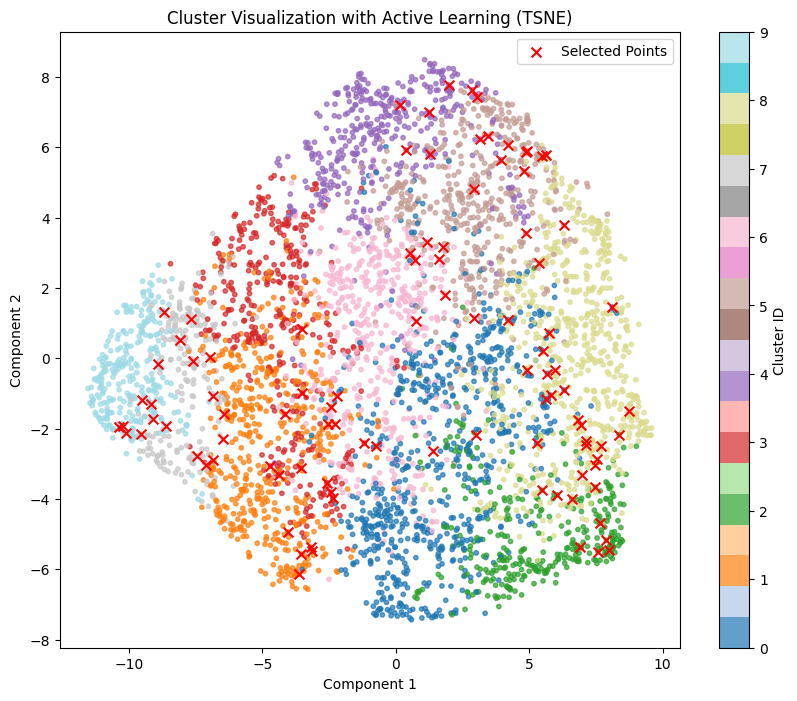

Selected 100 samples for labeling.


 15%|█▌        | 15/100 [00:01<00:09,  8.77it/s]

Epoch 10, Accuracy: 16.30%


 27%|██▋       | 27/100 [00:03<00:07,  9.26it/s]

Epoch 20, Accuracy: 18.18%


 34%|███▍      | 34/100 [00:04<00:08,  7.80it/s]

Epoch 30, Accuracy: 20.90%


 46%|████▌     | 46/100 [00:05<00:06,  8.83it/s]

Epoch 40, Accuracy: 23.08%


 54%|█████▍    | 54/100 [00:06<00:05,  8.07it/s]

Epoch 50, Accuracy: 25.78%


 67%|██████▋   | 67/100 [00:08<00:03,  9.17it/s]

Epoch 60, Accuracy: 25.14%


 74%|███████▍  | 74/100 [00:09<00:03,  7.78it/s]

Epoch 70, Accuracy: 24.12%


 85%|████████▌ | 85/100 [00:10<00:01,  8.16it/s]

Epoch 80, Accuracy: 23.38%


 96%|█████████▌| 96/100 [00:12<00:00,  8.49it/s]

Epoch 90, Accuracy: 25.24%


100%|██████████| 100/100 [00:13<00:00,  7.47it/s]


Epoch 100, Accuracy: 25.60%


Extracting features: 100%|██████████| 70/70 [00:01<00:00, 54.98it/s]


Davies-Bouldin Index: 1.9818745563254834


c:\Users\kubko\anaconda3\envs\DeeplearnignDTU\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


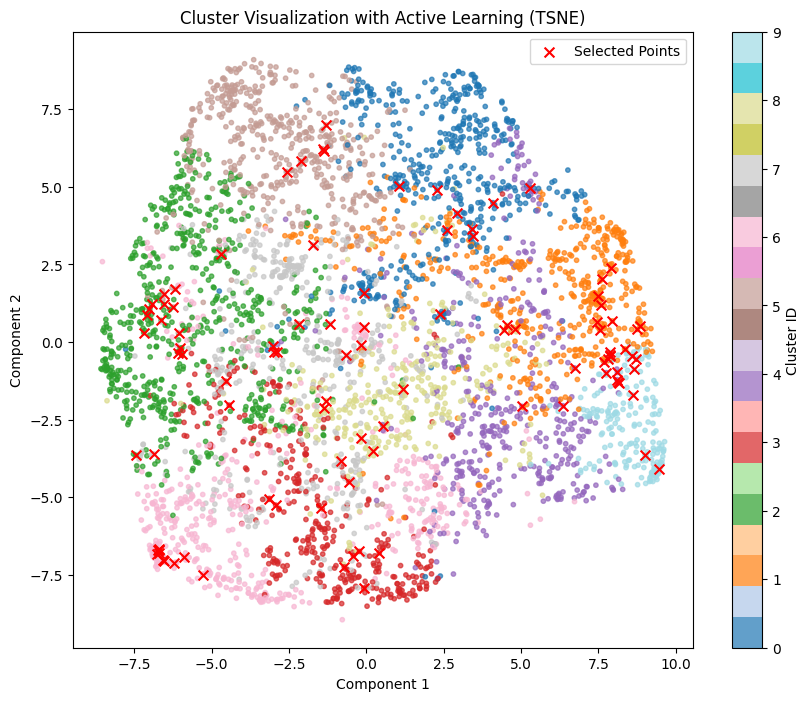

Selected 100 samples for labeling.


 11%|█         | 11/100 [00:02<00:23,  3.80it/s]

Epoch 10, Accuracy: 23.10%


 21%|██        | 21/100 [00:03<00:20,  3.88it/s]

Epoch 20, Accuracy: 27.56%


 33%|███▎      | 33/100 [00:05<00:13,  4.89it/s]

Epoch 30, Accuracy: 28.24%


 41%|████      | 41/100 [00:07<00:16,  3.63it/s]

Epoch 40, Accuracy: 28.20%


 51%|█████     | 51/100 [00:09<00:13,  3.70it/s]

Epoch 50, Accuracy: 29.80%


 62%|██████▏   | 62/100 [00:11<00:09,  3.81it/s]

Epoch 60, Accuracy: 29.90%


 72%|███████▏  | 72/100 [00:13<00:06,  4.05it/s]

Epoch 70, Accuracy: 29.98%


 82%|████████▏ | 82/100 [00:15<00:04,  4.32it/s]

Epoch 80, Accuracy: 29.98%


 92%|█████████▏| 92/100 [00:17<00:01,  4.69it/s]

Epoch 90, Accuracy: 29.94%


100%|██████████| 100/100 [00:19<00:00,  5.22it/s]


Epoch 100, Accuracy: 30.24%


Extracting features: 100%|██████████| 69/69 [00:01<00:00, 57.20it/s]


Davies-Bouldin Index: 1.9145891075356427


c:\Users\kubko\anaconda3\envs\DeeplearnignDTU\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


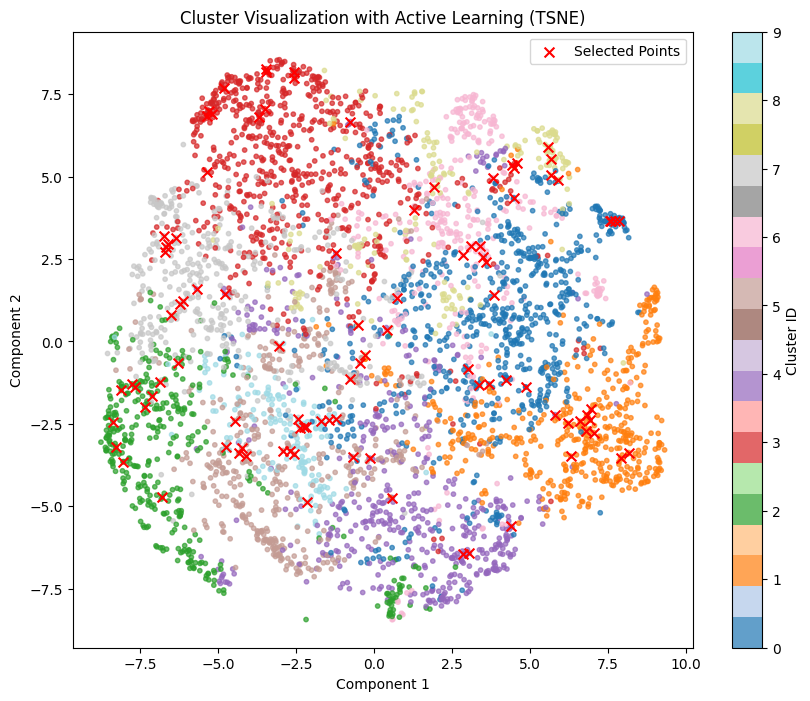

Selected 100 samples for labeling.


 11%|█         | 11/100 [00:02<00:34,  2.58it/s]

Epoch 10, Accuracy: 31.02%


 21%|██        | 21/100 [00:05<00:27,  2.89it/s]

Epoch 20, Accuracy: 32.32%


 31%|███       | 31/100 [00:07<00:27,  2.53it/s]

Epoch 30, Accuracy: 33.90%


 41%|████      | 41/100 [00:10<00:20,  2.92it/s]

Epoch 40, Accuracy: 33.78%


 51%|█████     | 51/100 [00:12<00:16,  2.93it/s]

Epoch 50, Accuracy: 33.84%


 61%|██████    | 61/100 [00:14<00:13,  2.97it/s]

Epoch 60, Accuracy: 33.78%


 71%|███████   | 71/100 [00:16<00:10,  2.80it/s]

Epoch 70, Accuracy: 33.86%


 81%|████████  | 81/100 [00:19<00:06,  2.91it/s]

Epoch 80, Accuracy: 33.82%


 91%|█████████ | 91/100 [00:21<00:03,  2.79it/s]

Epoch 90, Accuracy: 33.56%


100%|██████████| 100/100 [00:23<00:00,  4.22it/s]


Epoch 100, Accuracy: 33.98%


Extracting features: 100%|██████████| 67/67 [00:01<00:00, 62.31it/s]


Davies-Bouldin Index: 1.9701065132037368


c:\Users\kubko\anaconda3\envs\DeeplearnignDTU\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


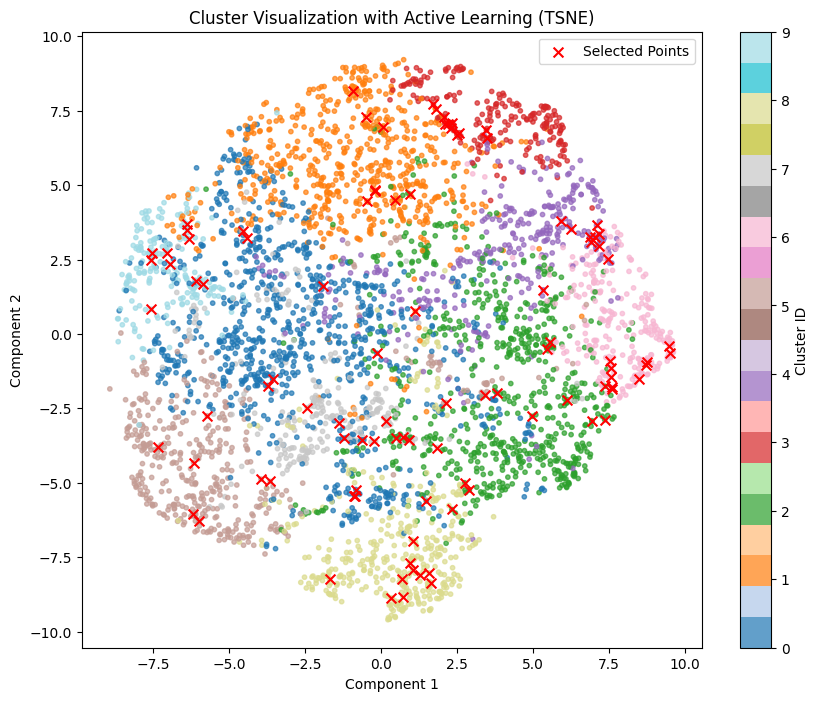

Selected 100 samples for labeling.


 11%|█         | 11/100 [00:03<00:34,  2.56it/s]

Epoch 10, Accuracy: 34.52%


 21%|██        | 21/100 [00:05<00:30,  2.56it/s]

Epoch 20, Accuracy: 35.90%


 31%|███       | 31/100 [00:08<00:28,  2.40it/s]

Epoch 30, Accuracy: 37.24%


 41%|████      | 41/100 [00:11<00:22,  2.58it/s]

Epoch 40, Accuracy: 36.90%


 51%|█████     | 51/100 [00:13<00:18,  2.69it/s]

Epoch 50, Accuracy: 37.18%


 61%|██████    | 61/100 [00:16<00:14,  2.68it/s]

Epoch 60, Accuracy: 37.10%


 71%|███████   | 71/100 [00:18<00:10,  2.66it/s]

Epoch 70, Accuracy: 37.34%


 81%|████████  | 81/100 [00:21<00:07,  2.52it/s]

Epoch 80, Accuracy: 37.46%


 91%|█████████ | 91/100 [00:23<00:03,  2.75it/s]

Epoch 90, Accuracy: 37.32%


100%|██████████| 100/100 [00:26<00:00,  3.75it/s]


Epoch 100, Accuracy: 37.46%
400


 10%|█         | 10/100 [00:01<00:10,  8.67it/s]

Epoch 10, Accuracy: 8.68%


 20%|██        | 20/100 [00:02<00:10,  7.55it/s]

Epoch 20, Accuracy: 8.68%


 30%|███       | 30/100 [00:03<00:09,  7.41it/s]

Epoch 30, Accuracy: 8.68%


 40%|████      | 40/100 [00:05<00:08,  7.10it/s]

Epoch 40, Accuracy: 8.68%


 50%|█████     | 50/100 [00:07<00:07,  6.73it/s]

Epoch 50, Accuracy: 8.68%


 60%|██████    | 60/100 [00:08<00:05,  6.93it/s]

Epoch 60, Accuracy: 8.68%


 70%|███████   | 70/100 [00:10<00:04,  6.51it/s]

Epoch 70, Accuracy: 8.68%


 80%|████████  | 80/100 [00:11<00:03,  6.34it/s]

Epoch 80, Accuracy: 8.68%


 90%|█████████ | 90/100 [00:13<00:01,  6.35it/s]

Epoch 90, Accuracy: 8.68%


100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 100, Accuracy: 8.68%
100


 15%|█▌        | 15/100 [00:01<00:09,  9.24it/s]

Epoch 10, Accuracy: 13.50%


 27%|██▋       | 27/100 [00:02<00:07,  9.13it/s]

Epoch 20, Accuracy: 17.22%


 38%|███▊      | 38/100 [00:04<00:06, 10.31it/s]

Epoch 30, Accuracy: 20.04%


 44%|████▍     | 44/100 [00:05<00:08,  6.94it/s]

Epoch 40, Accuracy: 21.96%


 53%|█████▎    | 53/100 [00:07<00:08,  5.78it/s]

Epoch 50, Accuracy: 22.12%


 63%|██████▎   | 63/100 [00:09<00:06,  5.83it/s]

Epoch 60, Accuracy: 22.36%


 74%|███████▍  | 74/100 [00:10<00:03,  6.78it/s]

Epoch 70, Accuracy: 22.64%


 85%|████████▌ | 85/100 [00:12<00:02,  6.95it/s]

Epoch 80, Accuracy: 22.60%


 94%|█████████▍| 94/100 [00:13<00:00,  7.29it/s]

Epoch 90, Accuracy: 22.80%


100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


Epoch 100, Accuracy: 22.88%
200


 11%|█         | 11/100 [00:01<00:22,  3.92it/s]

Epoch 10, Accuracy: 23.94%


 21%|██        | 21/100 [00:03<00:20,  3.77it/s]

Epoch 20, Accuracy: 29.40%


 31%|███       | 31/100 [00:05<00:19,  3.51it/s]

Epoch 30, Accuracy: 29.30%


 42%|████▏     | 42/100 [00:07<00:13,  4.41it/s]

Epoch 40, Accuracy: 28.62%


 52%|█████▏    | 52/100 [00:09<00:10,  4.73it/s]

Epoch 50, Accuracy: 29.82%


 62%|██████▏   | 62/100 [00:11<00:08,  4.59it/s]

Epoch 60, Accuracy: 30.26%


 72%|███████▏  | 72/100 [00:13<00:06,  4.65it/s]

Epoch 70, Accuracy: 30.14%


 81%|████████  | 81/100 [00:15<00:04,  4.20it/s]

Epoch 80, Accuracy: 30.22%


 92%|█████████▏| 92/100 [00:17<00:01,  4.25it/s]

Epoch 90, Accuracy: 30.18%


100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


Epoch 100, Accuracy: 30.36%
400


 11%|█         | 11/100 [00:02<00:32,  2.71it/s]

Epoch 10, Accuracy: 33.14%


 21%|██        | 21/100 [00:05<00:30,  2.59it/s]

Epoch 20, Accuracy: 37.22%


 31%|███       | 31/100 [00:07<00:25,  2.70it/s]

Epoch 30, Accuracy: 38.06%


 41%|████      | 41/100 [00:10<00:22,  2.60it/s]

Epoch 40, Accuracy: 38.40%


 51%|█████     | 51/100 [00:12<00:18,  2.68it/s]

Epoch 50, Accuracy: 38.58%


 61%|██████    | 61/100 [00:15<00:14,  2.76it/s]

Epoch 60, Accuracy: 38.80%


 71%|███████   | 71/100 [00:17<00:11,  2.55it/s]

Epoch 70, Accuracy: 38.76%


 81%|████████  | 81/100 [00:20<00:06,  2.72it/s]

Epoch 80, Accuracy: 38.82%


 91%|█████████ | 91/100 [00:23<00:03,  2.70it/s]

Epoch 90, Accuracy: 38.84%


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]

Epoch 100, Accuracy: 38.52%
800


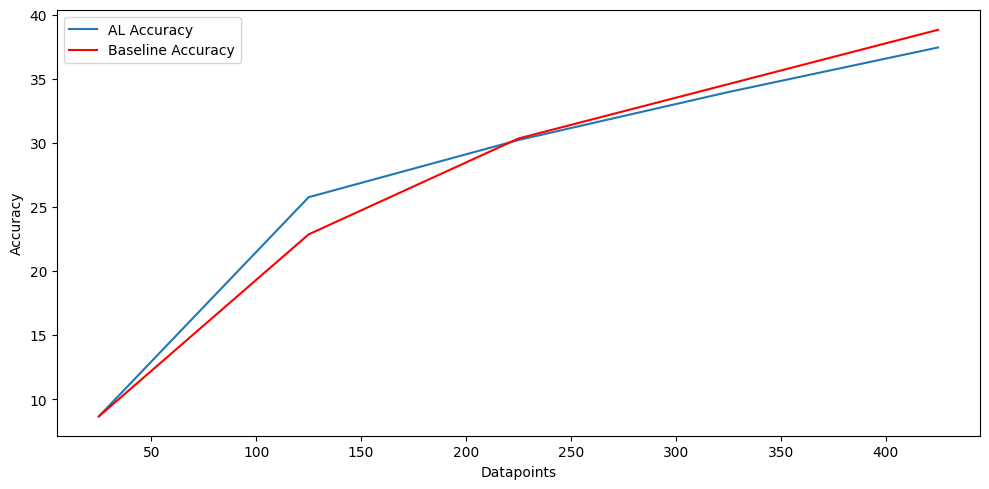

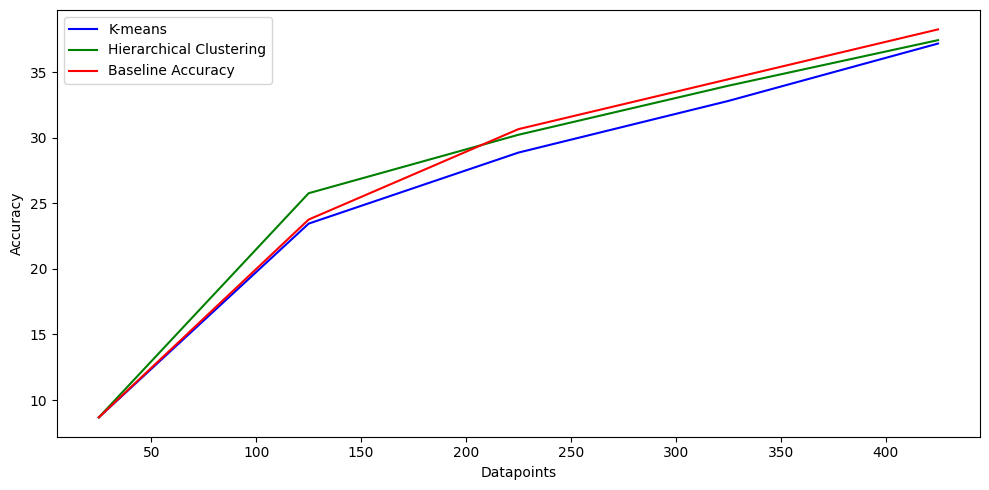

In [17]:
datapoints1,accuracies1,baseline_datapoint_list1,baseline_accuracy_list1=run_active_learning(train_dataset,start_train_dataset,unlabbelled_dataset,start_unlabbelled_dataset,model,model_parameters,val_loader,criterion,optimizer,device,label_iterations,cluster=label_iteration_with_clustering)
datapoints,accuracies,baseline_datapoint_list,baseline_accuracy_list=run_active_learning(train_dataset,start_train_dataset,unlabbelled_dataset,start_unlabbelled_dataset,model,model_parameters,val_loader,criterion,optimizer,device,label_iterations,cluster=label_iteration_with_Herar)
# Ensure the lists are numpy arrays
baseline_datapoint_list1 = np.array(baseline_datapoint_list1)
baseline_datapoint_list = np.array(baseline_datapoint_list)

baseline_accuracy_list1 = np.array(baseline_accuracy_list1)
baseline_accuracy_list = np.array(baseline_accuracy_list)

# Compute the element-wise mean
mean_baseline_datapoints = (baseline_datapoint_list1 + baseline_datapoint_list) / 2
mean_baseline_accuracy = (baseline_accuracy_list1 + baseline_accuracy_list) / 2

plt.figure(figsize=(10, 5))
plt.plot(datapoints1, accuracies1, label='K-means',color='blue')
plt.plot(datapoints, accuracies, label='Hierarchical Clustering',color='green')
plt.plot(mean_baseline_datapoints,mean_baseline_accuracy, label='Baseline Accuracy', color='red')
plt.xlabel('Datapoints')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
#plt.savefig('figs/accuracy.png')
plt.show()